design and train at least 3 different deep autoencoders or GANs, and test
each for two generative tasks

1) Generate facial sketch from photos;
2) Generate facial photos from sketch;

In [ ]:
#!pip install image_similarity_measures

In [ ]:
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn as skl
import skimage
#import tensorflow_probability as tfp

import keras
from keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, Dropout, Input, Lambda, BatchNormalization, LeakyReLU, Flatten
from keras.preprocessing.image import img_to_array
from keras.models import Model
#from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
import keras.backend as K
# import image_similarity_measures
# from image_similarity_measures.quality_metrics import rmse, psnr

import glob
import imageio
import time
from tqdm import tqdm 
import random

import os
import re
import cv2

Folders of images are uploaded on google drive and accessed by colab through mounting and mentioning the full path 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load dataset

In [ ]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [ ]:
semi_path = 'drive/MyDrive/Labs/Coursework/Comp Vision'

image_path_train = semi_path + '/ImageDataset/Dataset/CUHK_training_cropped_photos' 
img_array_train = []

sketch_path_train = semi_path + '/ImageDataset/Dataset/CUHK_training_cropped_sketches'
sketch_array_train = []

image_path_test = semi_path +'/ImageDataset/Dataset/CUHK_testing_cropped_photos' 
img_array_test = []

sketch_path_test = semi_path +'/ImageDataset/Dataset/CUHK_testing_cropped_sketches'
sketch_array_test = []

In [ ]:
image_file_train = sorted_alphanumeric(os.listdir(image_path_train))
sketch_file_train = sorted_alphanumeric(os.listdir(sketch_path_train))
image_file_test = sorted_alphanumeric(os.listdir(image_path_test))
sketch_file_test = sorted_alphanumeric(os.listdir(sketch_path_test))

In [ ]:
image_files = image_file_train + image_file_test
sketch_files = sketch_file_train + sketch_file_test

## Loading and augmenting images

In [ ]:
img_array=[]
sketch_array=[]
SIZE = 256

In [ ]:
for i in tqdm(image_file_train):
    image = cv2.imread(image_path_train + '/' + i,1)
    img_array.append(img_to_array(image))  
    
for i in tqdm(sketch_file_train):
    image = cv2.imread(sketch_path_train + '/' + i,1)
    sketch_array.append(img_to_array(image))

for i in tqdm(image_file_test):
    image = cv2.imread(image_path_test + '/' + i,1)   
    img_array.append(img_to_array(image))  
    
for i in tqdm(sketch_file_test):
    image = cv2.imread(sketch_path_test + '/' + i,1)
    sketch_array.append(img_to_array(image))

100%|██████████| 100/100 [00:00<00:00, 176.99it/s]


In [ ]:
# #change to grayscale
# tf.compat.v1.image.rgb_to_grayscale
# tf.image.rgb_to_grayscale(
#     images, name=None
# )

In [ ]:
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, (SIZE, SIZE))
    # image = image.astype('float32') / 255.0
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, (SIZE, SIZE))
    # image = image.astype('float32') / 255.0

    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, (SIZE, SIZE))
    # image = image.astype('float32') / 255.0
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, (SIZE, SIZE))
    # image = image.astype('float32') / 255.0

In [ ]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)
    plt.show()

In [ ]:
# image = cv2.imread(sketch_path_test + '/' + image_file_test[0],1)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image2 = cv2.resize(image, (SIZE, SIZE))
# COLOR_BGR2Lab 
img_array_RGB= []
img_array_LAB= []
for i in tqdm(img_array):
    image = i
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    imagereshaped = image.astype('float32') / 255.0
    img_array_RGB.append(img_to_array(imagereshaped))  

    image2 = i
    image2 = cv2.resize(image2, (SIZE, SIZE))
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2LAB)
    imagereshaped2 = image2.astype('float32') / 255.0
    img_array_LAB.append(img_to_array(imagereshaped2))  
# plt.imshow( img_to_array(image2))

100%|██████████| 188/188 [00:00<00:00, 225.43it/s]


In [ ]:

sketch_array_changed= []
for image in tqdm(sketch_array):
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    imagereshaped = image.astype('float32') / 255.0
    sketch_array_changed.append(img_to_array(imagereshaped))  
    
# plt.imshow( img_to_array(image2))

100%|██████████| 188/188 [00:00<00:00, 710.15it/s]


In [ ]:
img_array = img_array_RGB 
sketch_array = sketch_array_changed

In [ ]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 188
Total number of images: 188


# Visualizing images
Here i have plotted all augmented images and its augmented sketches

In [ ]:
ls = [i for i in range(0,20,5)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])



## Slicing and reshaping

Out of 188 images train images consist 80% images while test images contains 20% images


In [ ]:
import sklearn.model_selection as sklms

In [ ]:
train_images, test_images, train_sketch_images, test_sketch_images =sklms.train_test_split(img_array, sketch_array, train_size= 0.8, shuffle= True)

In [ ]:
# reshaping
train_sketch_images = np.reshape(train_sketch_images,(len(train_sketch_images),SIZE,SIZE,3))
train_images = np.reshape(train_images, (len(train_images),SIZE,SIZE,3))
print('Train color image shape:',train_images.shape)

test_sketch_images = np.reshape(test_sketch_images,(len(test_sketch_images),SIZE,SIZE,3))
print('Test sketch image shape',test_sketch_images.shape)

test_images = np.reshape(test_images, (len(test_images),SIZE,SIZE,3))
print('Test color image shape',test_images.shape)

Train color image shape: (150, 256, 256, 3)
Test sketch image shape (38, 256, 256, 3)
Test color image shape (38, 256, 256, 3)


# Defining common methods and variables

In [ ]:
encoder_input = keras.Input(shape = (SIZE, SIZE, 3))

In [ ]:
listOfOptimizers = [ 'RMSProp', 'SGD', 'Adam']
listOfLossFunctions = ['mean_absolute_error', 'mean_squared_error', 'binary_crossentropy']
listOfMetrics = ['acc', 'mae', 'mse', 'binary_crossentropy']
learning_rate = 0.001
number_of_epochs = 100

In [ ]:
def show_image_to_sketch(real,sketch, predicted, title):
    fig = plt.figure(figsize = (9,7))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 10, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 10, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 10, color = 'gold')
    plt.imshow(predicted)
    plt.figtext(0.25,0.7, title, wrap=False)
    #plt.tight_layout()
    plt.show()

In [ ]:
def show_sketch_to_image(real,sketch, predicted, title):
    plt.figure(figsize = (9,7))
    plt.subplot(1,3,1)
    plt.title("Sketch",fontsize = 12, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("Image",fontsize = 12, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 12, color = 'gold')
    plt.imshow(predicted)
    plt.figtext(0.25,0.7, title, wrap=False)
    plt.show()

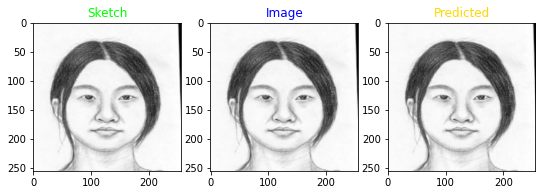

In [ ]:
show_sketch_to_image(sketch_array[i],sketch_array_changed[i],sketch_array_changed[i], "")

In [1]:
def get_similarity_measures(image1, image2):
  mae = tf.keras.metrics.mean_absolute_error(image1, image2)
  print(f'MAE: {mae}')
  ssim_val =  np.mean(tf.image.ssim(image1, image2, max_val = 1))
  print(f'SSIM: {ssim_val}')
  psnr_val = tf.image.psnr(image1, image2, max_val = 1)
  print(f'PSNR: {psnr_val}')
  ssim_val_multi =  np.mean(tf.image.ssim_multiscale(image1, image2, max_val = 1))
  print(f'Multiscale SSIM: {ssim_val_multi}')


From - https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/colorization-autoencoder-cifar10-3.4.1.py

## Downsample layer

In [ ]:
def deep_dense(units, activation='relu'):
    # downsample = tf.keras.models.Sequential()
    # downsample.add(Dense(units = units, use_bias = False, kernel_initializer = 'random_normal'))
    return Dense(units = units, activation=activation, use_bias = False, kernel_initializer = 'random_normal')

In [ ]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
      downsample.add(BatchNormalization())
    downsample.add(LeakyReLU())
    return downsample

## Upsample Layer

In [ ]:
def upsample_dense(units, activation='relu'):
    # upsample = tf.keras.models.Sequential()
    # upsample.add(keras.layers.Dense(units = units, use_bias = False, kernel_initializer = 'random_normal'))
    return Dense(units = units, activation=activation, kernel_initializer = 'random_normal')

In [ ]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(Dropout(0.1))
    upsample.add(LeakyReLU()) 
    return upsample

# Building Models 

## 1\. Deep AE

sequence of 
 * downsample layer for encoder 

 * upsample layer for decoder

In [ ]:
flat_size = SIZE * SIZE
i=0

In [ ]:
from tensorflow.python.ops.gen_array_ops import Reshape
#@title
def model():
    #x = deep_dense(SIZE)()
    model_input = Flatten()(encoder_input)
    x = deep_dense(SIZE )(model_input)
    x = deep_dense(SIZE/2)(x)
    x = deep_dense(SIZE/4)(x)
    encoder_output = deep_dense(SIZE/8)(x)
   
    #encoder_output = deep_dense(512,4)(x)
    
    decoder_input = deep_dense(SIZE/4)(encoder_output)
    x = deep_dense(SIZE/2)(decoder_input)
    x = deep_dense(SIZE)(x)
    x = deep_dense(SIZE * SIZE * 3,  activation='sigmoid')(x)
    decoder_output = keras.layers.Reshape(target_shape=(256,256,3))(x)

    #x = tf.keras.layers.Conv2DTranspose(8,(2,2),padding = 'same')(x)
    #decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2), padding = 'same')(x)

    return tf.keras.Model(encoder_input, decoder_output)

In [ ]:
# to get summary of model

ae_model2 = model()
#ae_model.summary()
ae_fit_history_s2f = []
ae_fit_history_f2s = []
listOfOptimizers = [ 'Adam']

### Face2Sketch

In [ ]:
#@title
for opt in listOfOptimizers:
  for loss in listOfLossFunctions:
    title = f"Model with Loss function {loss}  and Optimizer {opt}"
    print(title)
    # Training
    if opt == "SGD":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif opt == "RMSProp":
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    ae_model1 = model()
    ae_model1.compile(optimizer = optimizer, loss = loss, metrics = listOfMetrics)
    ae_fit = ae_model1.fit(train_images, train_sketch_images, epochs = number_of_epochs, verbose = 1)
    ae_fit_history_f2s.append(ae_fit)

    #Evalution on test data
    prediction_on_test_data = ae_model1.evaluate(test_images, test_sketch_images)
    print (prediction_on_test_data)
    print("Loss: ", prediction_on_test_data[0])
    print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))
    
    #Showing images
    #ls = random.sample(range(1, len(test_images)), 3)
    #print(f"length {len(test_images)}, samples = {ls}")
    #for i in ls:
      # Prediction
    predicted_image = ae_model1.predict(test_images[i].reshape(1,SIZE,SIZE,3))
    predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
  #if (i== 0):
    print("Images for ", title)
    show_image_to_sketch(test_images[i],test_sketch_images[i],predicted, title)

In [ ]:
#SELECTED - Model with Loss function mean_absolute_error  and Optimizer Adam
ae_fit_history_f2s = []
ae_model1 = model()

ae_model1.compile(optimizer = 'adam', loss = 'mae', metrics = listOfMetrics)
ae_fit = ae_model1.fit(train_images, train_sketch_images, epochs = number_of_epochs, verbose = 1)
ae_fit_history_f2s.append(ae_fit)

#Evalution on test data
prediction_on_test_data = ae_model1.evaluate(test_images, test_sketch_images)
print (prediction_on_test_data)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

#Showing images
predicted_image = ae_model1.predict(test_images[i].reshape(1,SIZE,SIZE,3))
predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
i=0
print("Images for ", title)
show_image_to_sketch(test_images[i],test_sketch_images[i],predicted, title)

### Sketch2face

In [ ]:
ae_model2 = model();
ae_fit_history_s2f=[]
#SELECTED - Model with Loss function mean_absolute_error  and Optimizer Adam

ae_model2.compile(optimizer = 'adam', loss = 'mae', metrics = listOfMetrics)
ae_fit = ae_model2.fit(train_sketch_images, train_images, epochs = number_of_epochs, verbose = 0)
ae_fit_history_s2f.append(ae_fit)

#Evalution on test data
prediction_on_test_data = ae_model2.evaluate(test_sketch_images, test_images)
print (prediction_on_test_data)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

predicted_image = ae_model2.predict(test_sketch_images[i].reshape(1,SIZE,SIZE,3))
predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)

i=0
title = f"Model with Loss function {loss}  and Optimizer {opt}"
print("Images for ", title)
show_sketch_to_image(test_sketch_images[i],test_images[i],predicted, title)

In [ ]:
#@title
for opt in listOfOptimizers:
  for loss in listOfLossFunctions:
    title = f"Model with Loss function {loss}  and Optimizer {opt}"
    print(title)
    # Training
    if opt == "SGD":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif opt == "RMSProp":
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    ae_model2 = model();
    ae_model2.compile(optimizer = optimizer, loss = loss, metrics = listOfMetrics)
    ae_fit = ae_model2.fit(train_sketch_images, train_images, epochs = number_of_epochs, verbose = 0)
    ae_fit_history_s2f.append(ae_fit)

    #Evalution on test data
    prediction_on_test_data = ae_model2.evaluate(test_sketch_images, test_images)
    print (prediction_on_test_data)
    print("Loss: ", prediction_on_test_data[0])
    print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))
    
    #Showing images
    # ls = random.sample(range(1, len(test_sketch_images)), 10)
    # print(f"length {len(test_images)}, samples = {ls}")
    # for i in ls:
    #   # Prediction
    predicted_image = ae_model2.predict(test_sketch_images[i].reshape(1,SIZE,SIZE,3))
    predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
    #if (i == 0):
    print("Images for ", title)
    show_sketch_to_image(test_sketch_images[i],test_images[i],predicted, title)


### similarity scores

In [ ]:
get_similarity_measures(test_images[i],predicted)

In [ ]:
plt.plot(ae_fit_history_f2s[0].history["loss"], 'g--', label="face2sketch")
plt.plot(ae_fit_history_s2f[0].history["loss"], 'r--',label = "sketch2face")
plt.xlabel('Epochs');
plt.ylabel('Training Error');

## 2\. Convolutional AE

In [ ]:
listOfOptimizers = [  'Adam']
listOfLossFunctions = [ 'mean_squared_error', 'binary_crossentropy']
listOfMetrics = ['acc','mse']

In [ ]:
def conv_ae_model_build():
  x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
  x = MaxPool2D(pool_size = (2,2))(x)

  #x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
  x = MaxPool2D(pool_size = (2,2))(x)

  x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
  encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
  
  encoder = tf.keras.Model(encoder_input, encoder_output)

  decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
  x = UpSampling2D(size = (2,2))(decoder_input)
  x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2,2) )(x)

  x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2,2) )(x)
  x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  #x = UpSampling2D(size = (2,2) )(x)

  #x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  conv_decoder_output = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

  return Model(encoder_input, conv_decoder_output, name="ConvolutionalAEModel")



In [ ]:
# final conv model
conv_ae_model = conv_ae_model_build()
#conv_ae_model.summary()

### face2sketch

In [ ]:
conv_ae_model.compile(optimizer = "adam", loss = "mae", metrics = listOfMetrics)
conv_fit = conv_ae_model.fit(train_images, train_sketch_images, epochs = number_of_epochs, verbose = 1)
conv_fit_history_f2s.append(conv_fit)

#Evalution on test data
prediction_on_test_data = conv_ae_model.evaluate(test_images, test_sketch_images)
print (prediction_on_test_data)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

In [ ]:
i=0
predicted_image = conv_ae_model.predict(test_images[i].reshape(1,SIZE,SIZE,3))
predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
print("Images for ", title)
show_image_to_sketch(test_images[i],test_sketch_images[i],predicted, title)

In [ ]:
get_similarity_measures(test_sketch_images[i],predicted)

SSIM: 0.5648611187934875
PSNR: 11.825250625610352
SSIM: 0.6198849678039551


### sketch2face

In [ ]:
conv_ae_model2 = conv_ae_model_build()

In [ ]:
conv_fit_history_s2f=[]
conv_ae_model2.compile(optimizer = "adam", loss = "mae", metrics = listOfMetrics)
conv_fit = conv_ae_model2.fit(train_sketch_images, train_images, epochs = number_of_epochs, verbose = 1)
conv_fit_history_s2f.append(conv_fit)

#Evalution on test data
prediction_on_test_data = conv_ae_model2.evaluate(test_sketch_images, train_images)
print (prediction_on_test_data)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

In [ ]:
show_image_to_sketch(test_sketch_images[i],test_images[i] , predicted, title)
predicted_image = conv_ae_model2.predict(test_sketch_images[10].reshape(1,SIZE,SIZE,3))
predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
show_image_to_sketch(test_sketch_images[10],test_images[10] , predicted, title)

In [ ]:
get_similarity_measures(test_images[i] , predicted)

### similarity measures

In [ ]:
plt.plot(conv_fit_history_f2s[0].history["loss"], 'g--', label="face2sketch")
plt.plot(conv_fit_history_s2f[0].history["loss"], 'r-+',label = "sketch2face")
plt.xlabel('Epochs');
plt.ylabel('Training Error');

## 2\.1 Convolutional AE with relu and batch normalization

In [ ]:
#@title
def conv_model():
    x = downsample(SIZE/16, 4, False)(encoder_input)
    x = downsample(SIZE/8,4)(x)
    x = downsample(SIZE/4,4,False)(x)
    x = downsample(SIZE/2,4)(x)
    x = downsample(SIZE,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(SIZE,4,False)(decoder_input)
    x = upsample(SIZE/2,4, True)(x)
    x = upsample(SIZE/4,4)(x)
    x = upsample(SIZE/8,4)(x)
    x = upsample(SIZE/16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)

    return tf.keras.Model(encoder_input, decoder_output)

In [ ]:
# to get summary of model
#conv_model1.summary()
conv_fit_history_s2f = []
conv_fit_history_f2s = []

### Face2Sketch

In [ ]:
for opt in listOfOptimizers:
  for loss in listOfLossFunctions:
    title = f"Model with Loss function {loss}  and Optimizer {opt}"
    print(title)
    # Training
    if opt == "SGD":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif opt == "RMSProp":
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    conv_model1 = conv_model()
    conv_model1.compile(optimizer = optimizer, loss = loss, metrics = listOfMetrics)
    conv_fit = conv_model1.fit(train_images, train_sketch_images, epochs = number_of_epochs, verbose = 0)
    conv_fit_history_f2s.append(conv_fit)
    
    #Evalution on test data
    prediction_on_test_data = conv_model1.evaluate(test_images, test_sketch_images)
    print (prediction_on_test_data)
    print("Loss: ", prediction_on_test_data[0])
    print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))
    
    #Showing images
    ls = random.sample(range(1, len(test_images)), 3)
    #print(f"length {len(test_images)}, samples = {ls}")
    for i in ls:
      # Prediction
      predicted_image = conv_model1.predict(test_images[i].reshape(1,SIZE,SIZE,3))
      predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
      print("Images for ", title)
      show_image_to_sketch(test_images[i],test_sketch_images[i],predicted, title)

In [ ]:
print("Similarity measures for Face2Sketch - Convolutional")
get_similarity_measures(test_sketch_images[i],predicted)

In [ ]:
title = f"Model with Loss function {loss}  and Optimizer {opt}"
# Training
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_model1 = conv_model()
conv_model1.compile(optimizer = optimizer, loss = 'mae')
conv_fit = conv_model1.fit(train_images, train_sketch_images, epochs = number_of_epochs, verbose = 0)
conv_fit_history_f2s.append(conv_fit)

#Evalution on test data
prediction_on_test_data = conv_model1.evaluate(test_images, test_sketch_images)
print (prediction_on_test_data)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

#Showing images

predicted_image = conv_model1.predict(test_images[i].reshape(1,SIZE,SIZE,3))
predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
print("Images for ", title)
show_image_to_sketch(test_images[i],test_sketch_images[i],predicted, title)
get_similarity_metrics(test_sketch_images[i],predicted)

### Sketch2face

In [ ]:
for opt in listOfOptimizers:
  for loss in listOfLossFunctions:
    title = f"Model with Loss function {loss}  and Optimizer {opt}"
    print(title)
    # Training
    if opt == "SGD":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif opt == "RMSProp":
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    conv_model2 = conv_model()
    conv_model2.compile(optimizer = optimizer, loss = loss, metrics = listOfMetrics)
    conv_fit = conv_model2.fit(train_sketch_images, train_images, epochs = number_of_epochs, verbose = 0)
    conv_fit_history_s2f.append(conv_fit)

    #Evalution on test data
    prediction_on_test_data = conv_model2.evaluate(test_sketch_images, test_images)
    print (prediction_on_test_data)
    print("Loss: ", prediction_on_test_data[0])
    print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))
    
    #Showing images
    # ls = random.sample(range(1, len(test_sketch_images)), 3)
    # print(f"length {len(test_images)}, samples = {ls}")
    # for i in ls:
    #   # Prediction
    predicted_image = conv_model2.predict(test_sketch_images[i].reshape(1,SIZE,SIZE,3))
    predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
    print("Images for ", title)
    show_sketch_to_image(test_sketch_images[i],test_images[i],predicted, title)

In [ ]:
title = f"Model with Loss function {loss}  and Optimizer {opt}"
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_model2 = conv_model()
conv_model2.compile(optimizer = optimizer, loss = loss, metrics = listOfMetrics)
conv_fit = conv_model2.fit(train_sketch_images, train_images, epochs = number_of_epochs, verbose = 0)
conv_fit_history_s2f.append(conv_fit)

#Evalution on test data
prediction_on_test_data = conv_model2.evaluate(test_sketch_images, test_images)
print (prediction_on_test_data)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

predicted_image = conv_model2.predict(test_sketch_images[i].reshape(1,SIZE,SIZE,3))
predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
print("Images for ", title)
show_sketch_to_image(test_sketch_images[i],test_images[i],predicted, title)

In [ ]:
print("Similarity measures for Sketch2Face - Convolutional")
get_similarity_measures(test_images[i],predicted)

##  3\. Variational AE 


In [ ]:
m = 50
z_dim = 10
n_epoch = 20
img_size = 256
num_channels = 3

In [ ]:
original_dim = img_size * img_size * num_channels 
intermediate_dim = img_size
latent_dim = z_dim

##3\.2 vae


https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/

In [ ]:
# Encoder
x = tf.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

# for i in range(0,5):
#   encoder_conv_layer = Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_"+ i)(x)
#   encoder_norm_layer = BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
#   encoder_activ_layer = LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)


encoder_conv_layer1 = Conv2D(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = K.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = Flatten()(encoder_activ_layer5)

encoder_mu = Dense(units=z_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = Dense(units=z_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")


In [ ]:
def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + K.exp(log_variance/2) * epsilon
    return random_sample

In [ ]:
encoder_output = Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])
encoder = Model(x, encoder_output, name="vae_encoder_model")

In [ ]:
decoder_input = Input(shape=(z_dim), name="decoder_input")

In [ ]:
decoder_dense_layer1 = Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

In [ ]:
decoder_conv_tran_layer1 =  Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 =  BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 =  LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 =  Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 =  BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 =  LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 =  Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 =  BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 =  LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 =  Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output =  LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

In [ ]:
decoder = Model(decoder_input, decoder_output, name="decoder_model")

In [ ]:
def vae_model():
  vae_encoder_output = encoder(encoder_input)
  vae_decoder_output = decoder(vae_encoder_output)
  return tf.keras.Model(encoder_input, vae_decoder_output, name="VAEModel")

In [ ]:
#@title
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [ ]:
vae_model_f2s = vae_model()
#vae_model_f2s.compile(optimizer = optimizer, loss = loss, metrics = listOfMetrics)
    

In [ ]:
vae_model_f2s.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=loss_func(encoder_mu, encoder_log_variance))

In [ ]:
vae_fit = vae_model_f2s.fit(train_images, train_sketch_images, epochs = n_epoch, verbose = 1)


In [ ]:
vae_encoder_output = encoder(encoder_input)
vae_decoder_output = decoder(vae_encoder_output)
vae_model =  Model(encoder_input, vae_decoder_output, name="VAEModel")

In [ ]:
vae_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss=loss_func(encoder_mu, encoder_log_variance))
vae_model.fit(img_array_RGB, sketch_array_changed, epochs = n_epoch, verbose = 1)

Epoch 1/20


ValueError: ignored

In [ ]:
# to get summary of model

vae_model.summary()
vae_fit_history_s2f = []
vae_fit_history_f2s = []

Model: "VAEModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vae_encoder_model (Function  (None, 10)               5336500   
 al)                                                             
                                                                 
 decoder_model (Functional)  (None, 256, 256, 3)       2996867   
                                                                 
Total params: 8,333,367
Trainable params: 8,332,533
Non-trainable params: 834
_________________________________________________________________


In [ ]:
listOfOptimizers=["Adam"]
listOfLossFunctions = ["mae"]

### Face2Sketch

In [ ]:
for opt in listOfOptimizers:
  for loss in listOfLossFunctions:
    title = f"Model with Loss function {loss}  and Optimizer {opt}"
    print(title)
    # Training
    if opt == "SGD":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif opt == "RMSProp":
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    vae_model_f2s = vae_model()
    vae_model_f2s.compile(optimizer = optimizer, loss = loss, metrics = listOfMetrics)
    vae_fit = vae_model_f2s.fit(train_images, train_sketch_images, epochs = n_epoch, verbose = 1)
    vae_fit_history_f2s.append(vae_fit)

    #Evalution on test data
    prediction_on_test_data = vae_model_f2s.evaluate(test_images, test_sketch_images)
    print (prediction_on_test_data)
    print("Loss: ", prediction_on_test_data[0])
    print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))
    
    #Showing images
    ls = random.sample(range(1, len(test_images)), 3)
    #print(f"length {len(test_images)}, samples = {ls}")
    #for i in ls:
      # Prediction
    i=0
    predicted_image = vae_model_f2s.predict(test_images[i].reshape(1,SIZE,SIZE,3))
    predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
    print("Images for ", title)
    show_image_to_sketch(test_images[i],test_sketch_images[i],predicted, title)

Model with Loss function mae  and Optimizer Adam


ValueError: ignored

### Sketch2face

In [ ]:
for opt in listOfOptimizers:
  for loss in listOfLossFunctions:
    title = f"Model with Loss function {loss}  and Optimizer {opt}"
    print(title)
    # Training
    if opt == "SGD":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif opt == "RMSProp":
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    ae_model2.compile(optimizer = optimizer, loss = loss, metrics = listOfMetrics)
    ae_fit = ae_model2.fit(train_sketch_images, train_images, epochs = n_epoch, verbose = 0)
    ae_fit_history_s2f.append(ae_fit)

    #Evalution on test data
    prediction_on_test_data = ae_model2.evaluate(test_sketch_images, test_images)
    print (prediction_on_test_data)
    print("Loss: ", prediction_on_test_data[0])
    print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))
    
    #Showing images
    # ls = random.sample(range(1, len(test_sketch_images)), 3)
    # print(f"length {len(test_images)}, samples = {ls}")
    # for i in ls:
      # Prediction
    i=0
    predicted_image = ae_model2.predict(test_sketch_images[i].reshape(1,SIZE,SIZE,3))
    predicted =np.clip(predicted_image,0.0,1.0).reshape(SIZE,SIZE,3)
    print("Images for ", title)
    show_sketch_to_image(test_sketch_images[i],test_images[i],predicted, title)

## Specs

In [ ]:
!df -h

In [ ]:
!cat /proc/cpuinfo

# Rough notes - Please ignore

In [ ]:
# Changing activation function to sigmoid

## VAE - keras

In [ ]:
def sample_z(args):
  mu, log_sigma = args
  eps = K.random_normal(shape=( K.shape(mu)[0], z_dim ), mean=0, stddev=0.1)
  return mu + K.exp(log_sigma ) * eps  # / 2

In [ ]:
vae_encoder_input =  keras.Input(shape=(original_dim,))
x2 =  Dense(intermediate_dim, activation='relu', name= 'Encoderlayer1')(vae_encoder_input)
#x2 =  Dense(intermediate_dim/2, activation='relu', name= 'Encoderlayer2')(x1)

#x =  Dense(512, activation='relu')(encoder_inputs)

# get log sigma
mean_value = Dense(z_dim, name="mean")(x2)
log_sigma = Dense(z_dim, name="variance")(x2)

In [ ]:
# Sample z ~ Q(z|X)
encoder_output = Lambda(sample_z)([mean_value, log_sigma])
vae_encoder = Model(vae_encoder_input, [mean_value, log_sigma, encoder_output], name='encoder')

In [ ]:

#latent space
decoder_input = keras.Input(shape=(latent_dim,), name='sample_z')

# P(X|z) -- decoder
#decoder_hidden = Dense(128, activation='relu')
#h_p = decoder_hidden(z)
#y1 = Dense(intermediate_dim /2)(decoder_input)
decoder_hidden = Dense(intermediate_dim , activation='relu')(decoder_input)

#decoder_out = Dense(SIZE, activation='sigmoid')
decoder_out = Dense(original_dim, activation='sigmoid')(decoder_hidden)
vae_decoder = Model(decoder_input, decoder_out, name='decoder')

In [ ]:
vae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 196608)]     0           []                               
                                                                                                  
 Encoderlayer1 (Dense)          (None, 256)          50331904    ['input_7[0][0]']                
                                                                                                  
 mean (Dense)                   (None, 10)           2570        ['Encoderlayer1[0][0]']          
                                                                                                  
 variance (Dense)               (None, 10)           2570        ['Encoderlayer1[0][0]']          
                                                                                            

In [ ]:
vae_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sample_z (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_54 (Dense)            (None, 256)               2816      
                                                                 
 dense_55 (Dense)            (None, 196608)            50528256  
                                                                 
Total params: 50,531,072
Trainable params: 50,531,072
Non-trainable params: 0
_________________________________________________________________


In [ ]:
outputs = vae_decoder(vae_encoder(vae_encoder_input)[0])
vae_model = Model(encoder_input, outputs, name="VAEmodel")

ValueError: ignored

In [ ]:
# # Encoder model, to encode input into latent variable
# # We use the mean as the output as it is the center point, the representative of the gaussian


# # Generator model, generate new data given latent variable z
# d_in = Input(shape=(z_dim,))
# d_h = decoder_hidden(d_in)
# d_out = decoder_out(d_h)
# decoder = Model(d_in, d_out)

In [ ]:
def vae_loss(y_true, y_pred):
  #Calculate loss = reconstruction loss + KL loss for each data in minibatch 
  # E[log P(X|z)]
  recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
  # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
  kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mean_value) - 1 - log_sigma, axis= 1)
  return recon + kl

In [ ]:
vae_model.compile(optimizer='adam', loss=vae_loss)
vae_model.fit(train_images, train_sketch_images, batch_size=10, epochs=n_epoch, verbose=1)

Epoch 1/20


ValueError: ignored

## 3\.1 VAE labs

In [ ]:
inputs = keras.Input(shape=(original_dim,))
h = keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = keras.layers.Dense(latent_dim)(h)
z_log_sigma = keras.layers.Dense(latent_dim)(h)

In [ ]:
#@title
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = keras.layers.Lambda(sampling)([z_mean, z_log_sigma])


In [ ]:
#@title
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = keras.layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

NameError: ignored

In [ ]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=n_epoch,
        batch_size=32,
        validation_data=(x_test, x_test))

https://stackoverflow.com/questions/66720722/autoencoder-outputs-bw-images-from-color

## 4\. Black white images

ae_model

https://medium.com/analytics-vidhya/what-are-autoencoders-learn-how-to-enhance-a-blurred-image-using-an-autoencoder-58f45149e1f1

### RGB to grayscale

In [ ]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
# convert color train and test images to gray
img_array_gray = rgb2gray(img_array_LAB[0])
#sketch_array_gray = rgb2gray(sketch_array)

In [ ]:
# g=tf.image.rgb_to_grayscale(
#     train_images[0], name=None
# ).numpy()

# gg= np.expand_dims(g, axis=0)
# gg

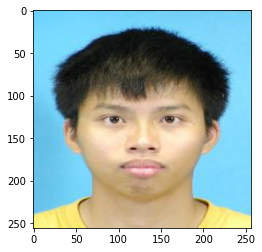

In [ ]:
plt.imshow(train_images[0])

In [ ]:
img_array_gray = []
sketch_array_gray = []

for i in tqdm(image_file_train):
    image = cv2.imread(image_path_train + '/' + i,0)
    # Sobel Edge Detection
    #image = cv2.GaussianBlur(image, ksize = (3,3), sigmaX=0, sigmaY=0)
    #sobelxy = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Sobel Edge 
    
    img_array_gray.append(img_to_array(image))  
    
# for i in tqdm(sketch_file_train):
#     image = cv2.imread(sketch_path_train + '/' + i,0)
#     # Sobel Edge Detection
#     #image = cv2.GaussianBlur(image, SigmaX=0, SigmaY=0)
#     sobelxy = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Sobel Edge 
#     sketch_array_gray.append(img_to_array(image))

for i in tqdm(image_file_test):
    image = cv2.imread(image_path_test + '/' + i,0)   
    # Sobel Edge Detection
    #image = cv2.GaussianBlur(image,  ksize = (3,3),sigmaX=0, sigmaY=0)
    #sobelxy = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Sobel Edge 
    img_array_gray.append(img_to_array(image))  
    
# for i in tqdm(sketch_file_test):
#     image = cv2.imread(sketch_path_test + '/' + i,0)
#     # Sobel Edge Detection
#     #image = cv2.GaussianBlur(image, SigmaX=0, SigmaY=0)
#     sobelxy = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Sobel Edge 
#     sketch_array_gray.append(img_to_array(image))

100%|██████████| 100/100 [00:00<00:00, 266.25it/s]


In [ ]:
# Sobel Edge Detection
sobelxy = cv2.Sobel(src=img_array_gray[0], ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Sobel Edge 

TypeError: ignored

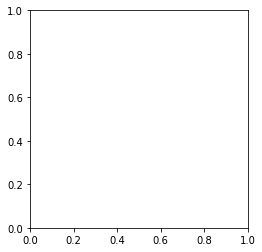

In [ ]:
plt.imshow(img_array_gray[0])

In [ ]:
#Train the Denoise encoder to improve the sketches / make it less blurry

In [ ]:
#Test it on the test data 

## Segnet

In [ ]:
## Model
# Here I have defined two blocks of networks. Encoder network takes 256 by 256 image and downsample it to 16 by 16 latent vector
# by passing our image via series of Convolution and Maxpooling layer. This downsampled 16 by 16 latent vector is upsampled by passing 
# through series of Convolution and UpSampling layer. The final decoder output is same as our encoder input. This upsamples output of decoder
# is compared with our sketches and reconstruction loss is calculated. This loss is minimized by updating weight and bias of network through
# backpropagation.

def segnet_ae_model_build():
  x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
  x = MaxPool2D(pool_size = (2,2))(x)

  x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
  x = MaxPool2D(pool_size = (2,2))(x)

  x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
  encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
  
  encoder = tf.keras.Model(encoder_input, encoder_output)

  decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
  x = UpSampling2D(size = (2,2))(decoder_input)
  x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2,2) )(x)

  x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2,2) )(x)
  x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2,2) )(x)

  x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  conv_decoder_output = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

  return Model(encoder_input, conv_decoder_output, name="Convolutional AE Model")



# Similarity measures

In [ ]:
tf.image.ssim_multiscale(
    img1, img2, max_val, power_factors=_MSSSIM_WEIGHTS, filter_size=11,
    filter_sigma=1.5, k1=0.01, k2=0.03
)

#This function assumes that img1 and img2 are image batches, i.e. the last three dimensions are [height, width, channels].